In [1]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts

Untimigated distribution

In [135]:
unmiti_dist = {'00000': 0.0030625,
 '00001': 0.01659375,
 '10000': 0.01428125,
 '10001': 0.06196875,
 '10010': 0.02559375,
 '10011': 0.01125,
 '10100': 0.07671875,
 '10101': 0.4980625,
 '10110': 0.00859375,
 '10111': 0.02121875,
 '11000': 0.0099375,
 '11001': 0.01984375,
 '11010': 0.00321875,
 '11011': 0.0045,
 '11100': 0.00665625,
 '11101': 0.0154375,
 '11110': 0.0016875,
 '11111': 0.00296875,
 '00010': 0.00684375,
 '00011': 0.0028125,
 '00100': 0.018875,
 '00101': 0.12825,
 '00110': 0.00271875,
 '00111': 0.00484375,
 '01000': 0.00528125,
 '01001': 0.010375,
 '01010': 0.00196875,
 '01011': 0.00284375,
 '01100': 0.00328125,
 '01101': 0.00759375,
 '01110': 0.000875,
 '01111': 0.00184375}

In [387]:
unmiti_dist['10101']

0.4980625

In [41]:
#miti q0:
miti_q0_dist = {'00000': 0.0008425688019963411,
 '01000': 0.00029296464250364935,
 '10000': 0.005517728278129252,
 '11000': 0.0008495865288482616,
 '10010': 0.009557865665057726,
 '11010': 0.00011979923194458203,
 '10100': 0.06206853165414746,
 '11100': 0.003947297092526912,
 '10110': 0.009785446610530138,
 '11110': 0.0005213892995868953,
 '00010': 0.0031092465877714894,
 '01010': 7.483798837566549e-05,
 '00100': 0.011606112342791098,
 '01100': 0.00146082241758777,
 '00110': 0.002777216793237879,
 '01110': 0.00019042180022025817,
 '00001': 0.019392526241271156,
 '01001': 0.0057443316847119,
 '10001': 0.06391632957338894,
 '11001': 0.011123026516999339,
 '10011': 0.0023778911658138384,
 '11011': 0.00045629778819690383,
 '10101': 0.5645739481099143,
 '11101': 0.016009989387912097,
 '10111': 0.02297261740880418,
 '11111': 0.0011256606608771992,
 '00011': 0.0003923078813631954,
 '01011': 0.00016058132743087563,
 '00101': 0.16515115027382174,
 '01101': 0.00752785064048203,
 '00111': 0.0060325019932496535,
 '01111': 0.00032115361050720075}

In [42]:
#miti q1:
miti_q1_dist = {'00000': 0.0049653598742532305,
 '01000': 0.0006505747318370273,
 '00001': 0.0206545122554311,
 '01001': 0.004945107819417521,
 '10001': 0.06174996368704016,
 '11001': 0.009567380317862712,
 '00101': 0.1933852066281297,
 '01101': 0.008804537212156247,
 '10101': 0.5764269302146358,
 '11101': 0.016113215288272018,
 '10000': 0.01846072432857463,
 '11000': 0.0023432799733195007,
 '00100': 0.020213268590082344,
 '01100': 0.0016252662961490228,
 '10100': 0.05641478049926081,
 '11100': 0.0036798922835781338}

In [43]:
#miti q2:
miti_q2_dist = {'00000': 0.0007307208180306509,
 '00100': 0.022210962841427893,
 '00001': 0.005353756230944865,
 '00101': 0.17536109996316238,
 '10000': 0.004333075277128686,
 '10100': 0.07603325224215804,
 '10001': 0.03306194359049275,
 '10101': 0.592670046884051,
 '10010': 0.006007177300611289,
 '10110': 0.01091069320003823,
 '10011': 0.004290798563499355,
 '10111': 0.02269858456944508,
 '11000': 0.000479512452982136,
 '11100': 0.0017721435598688302,
 '11001': 0.007821077665541576,
 '11101': 0.01270606380073602,
 '11010': 2.1974251729679483e-05,
 '11110': 0.00038462517303646665,
 '11011': 0.00014626502991052148,
 '11111': 9.153886125403737e-05,
 '00010': 0.0019126205174269319,
 '00110': 0.0031884495847766298,
 '00011': 0.0009337891849845806,
 '00111': 0.006067421218165642,
 '01000': 0.00018970155902379144,
 '01100': 0.0005772141863509325,
 '01001': 0.0036672423597316054,
 '01101': 0.006252709135676439,
 '01010': 2.4057384965945976e-05,
 '01110': 6.778691682292703e-06,
 '01011': 3.589999345514637e-05,
 '01111': 5.880390771058424e-05}

In [44]:
#miti q3:
miti_q3_dist = {'00000': 0.005984192016901224,
 '00100': 0.025363116817725264,
 '00001': 0.018563723954829643,
 '00101': 0.1728787970868529,
 '00011': 0.0029726634182245817,
 '00111': 0.007395234250907539,
 '10001': 0.05985201819899007,
 '10101': 0.5333937884568029,
 '10011': 0.00895802996997104,
 '10111': 0.021547071443084213,
 '00010': 0.008044473598554727,
 '00110': 0.004078600568571452,
 '10000': 0.01624224263866314,
 '10100': 0.0767537926624765,
 '10010': 0.024101133733037645,
 '10110': 0.013871121184407104}

In [45]:
#miti q4:
miti_q4_dist = {'00000': 9.783043175724626e-05,
 '10000': 0.005135927816629799,
 '00100': 0.00040916101340379804,
 '10100': 0.05119589461907852,
 '00010': 0.0001646112964508514,
 '10010': 0.006332754670209209,
 '00110': 2.44884473536488e-05,
 '10110': 0.02331656800371775,
 '01010': 2.3886368975988558e-05,
 '11010': 9.744904881802676e-05,
 '01110': 0.00010689714391425332,
 '11110': 0.0006442917855116173,
 '00011': 0.00060959881039227,
 '10011': 0.026000038216052002,
 '00111': 0.0021359167063795376,
 '10111': 0.16914174119418712,
 '01011': 0.000276031244978137,
 '11011': 0.001436737974435057,
 '01111': 0.0005911793638376277,
 '11111': 0.004650544661738176,
 '01000': 6.331494229546442e-05,
 '11000': 0.00021533870223753462,
 '01100': 0.00010445590858859957,
 '11100': 0.0010985106941588543,
 '00001': 0.0015791436324456185,
 '10001': 0.054940809851308524,
 '00101': 0.0070856038509032266,
 '10101': 0.6191954107657333,
 '01001': 0.0008922793331805622,
 '11001': 0.0040608414370297335,
 '01101': 0.002094447994487824,
 '11101': 0.01627829406981016}

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooli

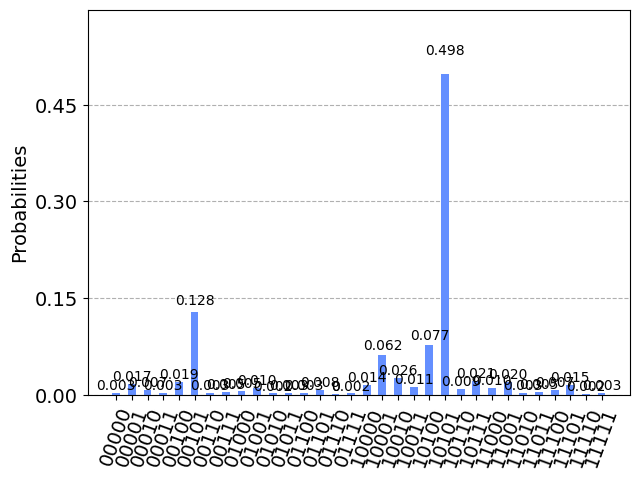

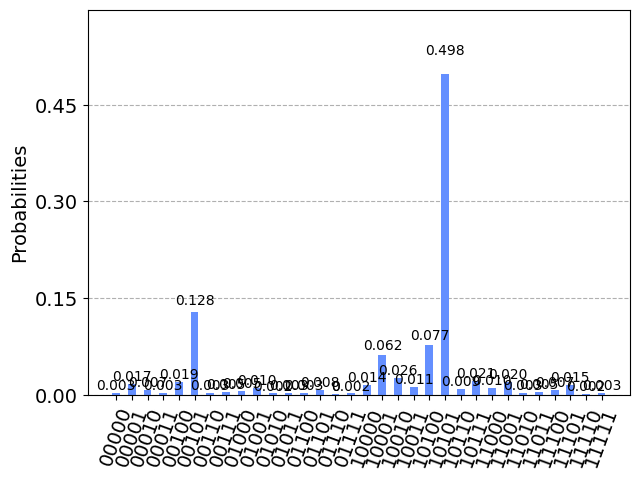

In [431]:
plot_histogram(unmiti_dist)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooli

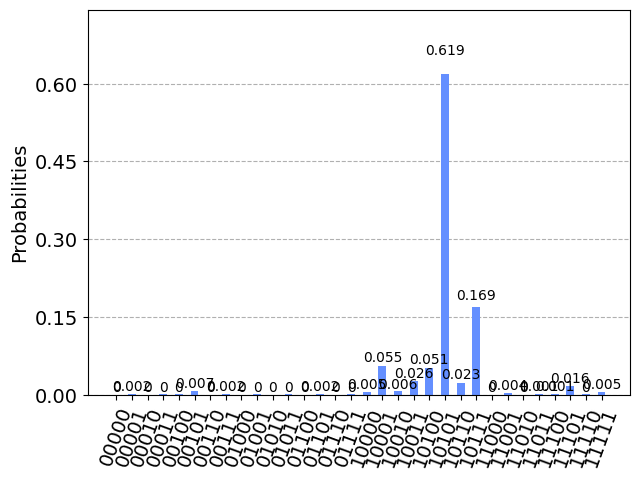

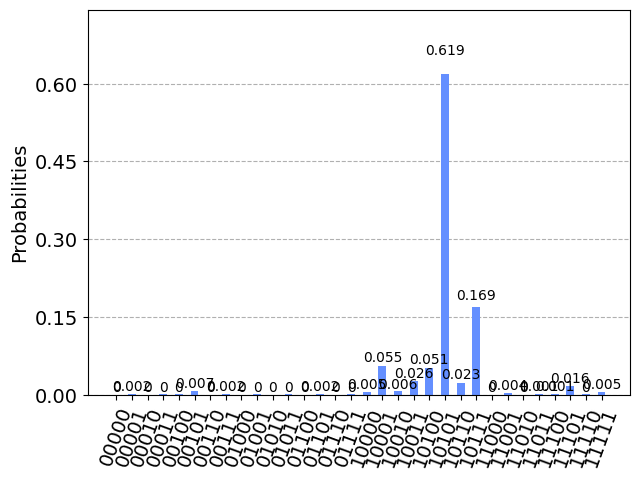

In [432]:
plot_histogram(miti_q4_dist)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:185: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/revilooli

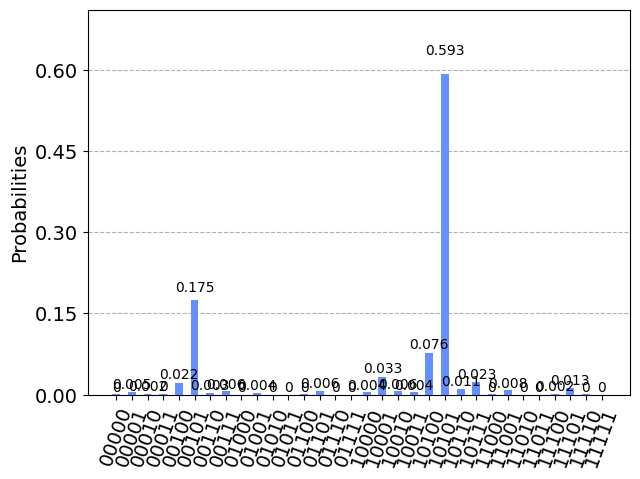

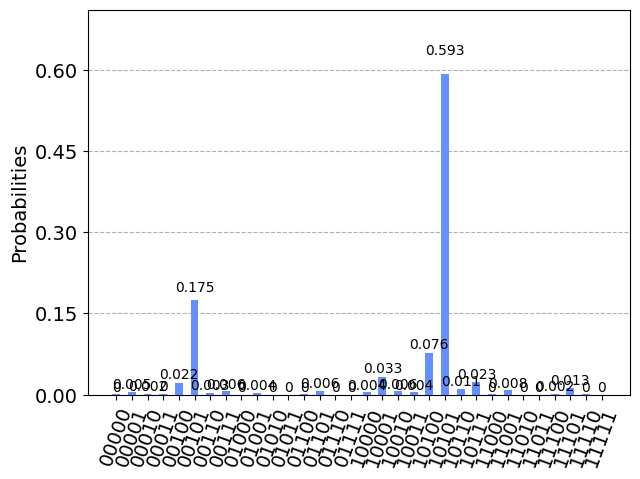

In [434]:
plot_histogram(miti_q2_dist)

In [46]:
qubits = 5
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [49]:
miti_dist_list = [miti_q0_dist, miti_q1_dist, miti_q2_dist, miti_q3_dist, miti_q4_dist]

In [50]:
def load_probs(miti_dist_list, bit_str):
    output_list = []
    for dist in miti_dist_list:
        try:
            miti_count = dist[bit_str]
        except:
            miti_count = 0
        output_list.append(miti_count)
    return output_list

In [51]:
load_probs(miti_dist_list, '10101')

[0.5645739481099143,
 0.5764269302146358,
 0.592670046884051,
 0.5333937884568029,
 0.6191954107657333]

In [52]:
#q0 bitflip
load_probs(miti_dist_list, '10100')

[0.06206853165414746,
 0.05641478049926081,
 0.07603325224215804,
 0.0767537926624765,
 0.05119589461907852]

In [57]:
#q1 bitflip
load_probs(miti_dist_list, '10111')

[0.02297261740880418,
 0,
 0.02269858456944508,
 0.021547071443084213,
 0.16914174119418712]

In [53]:
#q2 bitflip
load_probs(miti_dist_list, '10001')

[0.06391632957338894,
 0.06174996368704016,
 0.03306194359049275,
 0.05985201819899007,
 0.054940809851308524]

In [54]:
#q3 bitflip
load_probs(miti_dist_list, '11101')

[0.016009989387912097,
 0.016113215288272018,
 0.01270606380073602,
 0,
 0.01627829406981016]

In [58]:
#q4 bitflip
load_probs(miti_dist_list, '00101')

[0.16515115027382174,
 0.1933852066281297,
 0.17536109996316238,
 0.1728787970868529,
 0.0070856038509032266]

In [59]:
def combine_distribution(unmiti_dist, miti_dist_list):
    #given the mitigated distribution and the unmitigated distribution, return the combined distribution
    comb_dist = {}
    for bit_str in unmiti_dist.keys():
        probs_list = load_probs(miti_dist_list, bit_str)
        higher_count = 0
        lower_count = 0

        actual_count = unmiti_dist[bit_str]
    #     except:
    #         actual_count = 0
        for prob in probs_list:
            if prob > actual_count:
                higher_count += 1
            else:
                lower_count += 1
        miti_count = 0
        print(bit_str, "#higher", higher_count, "#lower", lower_count)
        if higher_count >= lower_count:
            miti_count = max(probs_list)
        else:
            miti_count = min(probs_list)
        comb_dist[bit_str] = miti_count
    return comb_dist
    

In [60]:
def avg_distribution(unmiti_dist, miti_dist_list):
    #given the mitigated distribution and the unmitigated distribution, return the combined distribution
    comb_dist = {}
    for bit_str in unmiti_dist.keys():
        probs_list = load_probs(miti_dist_list, bit_str)

        actual_count = sum(probs_list)/len(probs_list)
        comb_dist[bit_str] = actual_count
    return comb_dist

In [304]:
def bit_weight(dist, index):
    #bitwise distribution
    weight_0 = 0
    weight_1 = 0
    for key in dist.keys():
        if key[len(key) - 1 - index] == '0':
            weight_0 += dist[key]
        elif key[len(key) - 1 - index] == '1':
            weight_1 += dist[key]
        else:
            print("Incorrect key value")
    return weight_0, weight_1

In [377]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q0_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.11272183573525539 1xxxx 0.8872781642647447
x0xxx 0.9400247641870323 x1xxx 0.05997523581296767
xx0xx 0.12392788990380313 xx1xx 0.8760721100961969
xxx0x 0.9500739893812885 xxx1x 0.04992601061871153
xxxx0 0.22507659502732189 xxxx1 0.774923404972678


In [378]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q1_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.10835314657705471 1xxxx 0.8916468534229453
x0xxx 0.9999999999999999 x1xxx 0
xx0xx 0.12333690298773588 xx1xx 0.876663097012264
xxx0x 0.9522707460774077 xxx1x 0.04772925392259218
xxxx0 0.25524383340745616 xxxx1 0.7447561665925437


In [379]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q2_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.1287829590412384 1xxxx 0.8712170409587615
x0xxx 0.9432205225673077 x1xxx 0.056779477432692405
xx0xx 0.0690096121804595 xx1xx 0.9309903878195406
xxx0x 0.9657643919863439 xxx1x 0.03423560801365601
xxxx0 0.2265712275775163 xxxx1 0.7734287724224839


In [380]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q3_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.17443867322033707 1xxxx 0.8255613267796629
x0xxx 0.9090316718332416 x1xxx 0.0909683281667583
xx0xx 0.14471847752917208 xx1xx 0.8552815224708279
xxx0x 1.0 xxx1x 0
xxxx0 0.24528080171256733 xxxx1 0.7547191982874327


In [394]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q4_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.08903138089310117 1xxxx 0.9109686191068989
x0xxx 0.7644472650630487 x1xxx 0.23555273493695125
xx0xx 0.10192659377719601 xx1xx 0.898073406222804
xxx0x 0.9673654993260024 xxx1x 0.03263450067399762
xxxx0 0.016258846489344655 xxxx1 0.9837411535106554


In [400]:
def update_dist(unmiti_dist, miti_dist, index):
    Ppost = {}
    w0, w1 = bit_weight(miti_dist, index)
    u_w0, u_w1 = bit_weight(unmiti_dist, index)
    print("w0,1", w0,w1,u_w0, u_w1)
    if w0 == 0:
        w0 = 0.0000000000001
        w1 = 0.9999999999999
    if w1 == 0:
        w1 = 0.0000000000001
        w0 = 0.9999999999999
    if u_w0 == 0:
        u_w0 = 0.0000000000001
        u_w1 = 0.9999999999999
    if u_w1 == 0:
        u_w1 = 0.0000000000001
        u_w0 = 0.9999999999999
        
    for key in unmiti_dist.keys():
        if key[len(key) - 1 - index] == '0':
            Ppost[key] = unmiti_dist[key] / u_w0 * (w0)# / w1)
            #print(w0, w1, w0/w1, Ppost[key])
        elif key[len(key) - 1 - index] == '1':
            Ppost[key] = unmiti_dist[key] / u_w1 * (w1)# / w0)
            #print(w0, w1, w1/w0, Ppost[key])
        else:
            print("Incorrect key value")
    return Ppost

In [228]:
def combine_dist(orign_dist, dist_list):
    output_dist = {}
    for key in orign_dist:
        value = orign_dist[key]
        for dist in dist_list:
            value += dist[key]
        output_dist[key] = value
    return output_dist  

In [208]:
def H_distance_dict(p, q):
    # distance between p an d
    # p and q are np array probability distributions
    sum = 0.0
    for key in p.keys():
        sum += (np.sqrt(p[key]) - np.sqrt(q[key]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result

In [210]:
temp_post = unmiti_dist.copy()
threshold = 0.0001
h_dist = 1
while h_dist > threshold:
    temp_post0 = temp_post.copy()
    ppost_0 =  update_dist(temp_post, miti_q0_dist, 0)
    w0, w1 = bit_weight(ppost_0, 0)
    print(w0, w1, w1/w0)
    temp_post = combine_dist(ppost_0, temp_post)
    temp_post = norm_dict(temp_post)
    w0, w1 = bit_weight(temp_post, 0)
    print(w0, w1, w1/w0)
    h_dist = H_distance_dict(temp_post, temp_post0)

0.12704227408623753 7.871395621595927 61.95886903167955
0.035187887915320626 0.9648121120846798 27.418869652151116
0.12704227408623753 7.871395621595927 61.95886903167955
0.018028702746218116 0.9819712972537823 54.467107871073566
0.1270422740862375 7.871395621595927 61.95886903167956
0.016121795639892886 0.9838782043601074 61.02783004676794
0.1270422740862375 7.871395621595926 61.958869031679555
0.01590988029098102 0.9840901197090185 61.85402414793019
0.1270422740862375 7.871395621595928 61.95886903167957
0.01588633005355441 0.9841136699464457 61.94720030547646


In [235]:
temp_post = unmiti_dist.copy()
threshold = 0.0001
h_dist = 1
while h_dist > threshold:
    temp_post0 = temp_post.copy()
    ppost_0 =  update_dist(temp_post, miti_q1_dist, 1)
    w0, w1 = bit_weight(ppost_0, 1)
    print(w0, w1, w1/w0)
    temp_post = combine_dist(temp_post, [ppost_0])
    temp_post = norm_dict(temp_post)
    w0, w1 = bit_weight(temp_post, 1)
    print(w0, w1, w1/w0)
    h_dist = H_distance_dict(temp_post, temp_post0)

9999999999999.002 1.0000000000000999e-13 1.0000000000001996e-26
0.99999999999999 1.0378125000010002e-14 1.0378125000010106e-14
9999999999999.0 1.0000000000001e-13 1.0000000000001999e-26
1.0000000000000002 1.1037812500002004e-26 1.1037812500002001e-26


In [238]:
temp_post

{'00000': 0.0034171344886502327,
 '00001': 0.018515289933400753,
 '10000': 0.015935004707277104,
 '10001': 0.06914467031625929,
 '10010': 2.722062161247107e-27,
 '10011': 1.1965108401086187e-27,
 '10100': 0.08560270581261552,
 '10101': 0.555737647756198,
 '10110': 9.140013361940834e-28,
 '10111': 2.2567523900937554e-27,
 '11000': 0.011088252728477285,
 '11001': 0.02214163673768263,
 '11010': 3.4233504591996586e-28,
 '11011': 4.786043360434475e-28,
 '11100': 0.0074270372049234645,
 '11101': 0.017225147320338922,
 '11110': 1.7947662601629278e-28,
 '11111': 3.1574591613977437e-28,
 '00010': 7.27877427732743e-28,
 '00011': 2.9912771002715467e-28,
 '00100': 0.02106070644025245,
 '00101': 0.14310122389204646,
 '00110': 2.891567863595828e-28,
 '00111': 5.1516438949121075e-28,
 '01000': 0.005892813556958054,
 '01001': 0.011576414798284463,
 '01010': 2.0938939701900822e-28,
 '01011': 3.0245135124967855e-28,
 '01100': 0.00366121552355382,
 '01101': 0.0084730987830817,
 '01110': 9.306195423067032

In [239]:
temp_post = unmiti_dist.copy()
threshold = 0.0001
h_dist = 1
while h_dist > threshold:
    temp_post0 = temp_post.copy()
    ppost_0 =  update_dist(temp_post, miti_q2_dist, 2)
    w0, w1 = bit_weight(ppost_0, 2)
    print(w0, w1, w1/w0)
    temp_post = combine_dist(temp_post, [ppost_0])
    temp_post = norm_dict(temp_post)
    w0, w1 = bit_weight(temp_post, 2)
    print(w0, w1, w1/w0)
    h_dist = H_distance_dict(temp_post, temp_post0)

0.07412494595361609 13.49073496290646 181.9999298393867
0.018846727512060207 0.9811532724879395 52.05960938630273
0.07412494595361609 13.490734962906458 181.99992983938668
0.0063832864886753824 0.9936167135113247 155.65911310327442
0.07412494595361607 13.490734962906458 181.99992983938674
0.005527566550318605 0.9944724334496812 179.9114356013245
0.07412494595361607 13.490734962906458 181.99992983938674
0.005468814187184909 0.9945311858128151 181.85499667246026
0.07412494595361606 13.490734962906458 181.99992983938677
0.005464780343845435 0.9945352196561548 181.9899716145451


In [401]:
def bayesian_reconstruct(unmiti_dist, miti_dist_list, threshold = 0.0001):
    temp_dist = unmiti_dist.copy()
    h_dist = 1
    while h_dist > threshold:
        temp_dist_start = temp_dist.copy()
        ppost = [0] * len(miti_dist_list)
        for i in range(0, len(miti_dist_list)):
            ppost[i] = update_dist(temp_dist, miti_dist_list[i][0], miti_dist_list[i][1])
            #print("ppost weight", bit_weight(ppost[i], miti_dist_list[i][1]))
        temp_dist = combine_dist(temp_dist, ppost)
        temp_dist = norm_dict(temp_dist)
        h_dist = H_distance_dict(temp_dist, temp_dist_start)
        print(h_dist)
    return temp_dist

In [402]:
temp_post4 = bayesian_reconstruct(unmiti_dist, [[miti_q4_dist,4]])

w0,1 0.016258846489344655 0.9837411535106554 0.2180625 0.7819375
0.09645410140913833
w0,1 0.016258846489344655 0.9837411535106554 0.11716067324467233 0.8828393267553277
0.06228056249927989
w0,1 0.016258846489344655 0.9837411535106554 0.0667097598670085 0.9332902401329917
0.039685844989176836
w0,1 0.016258846489344655 0.9837411535106554 0.041484303178176585 0.9585156968218236
0.02430018110504619
w0,1 0.016258846489344655 0.9837411535106554 0.028871574833760617 0.9711284251662394
0.014111380488913023
w0,1 0.016258846489344655 0.9837411535106554 0.022565210661552645 0.9774347893384475
0.007782493666152437
w0,1 0.016258846489344655 0.9837411535106554 0.019412028575448634 0.9805879714245512
0.004123997865578589
w0,1 0.016258846489344655 0.9837411535106554 0.01783543753239665 0.9821645624676035
0.0021291328360868193
w0,1 0.016258846489344655 0.9837411535106554 0.017047142010870663 0.9829528579891293
0.0010827063002659578
w0,1 0.016258846489344655 0.9837411535106554 0.01665299425010765 0.9833

In [403]:
bit_weight(temp_post4, 4)

(0.016283480724392348, 0.9837165192756077)

In [397]:
temp_post = unmiti_dist.copy()
threshold = 0.0001
h_dist = 1
while h_dist > threshold:
    temp_post0 = temp_post.copy()
    ppost_0 =  update_dist(temp_post, miti_q4_dist, 4)
    w0, w1 = bit_weight(ppost_0, 4)
    print(w0, w1, w1/w0)
    temp_post = combine_dist(temp_post, [ppost_0])
    temp_post = norm_dict(temp_post)
    w0, w1 = bit_weight(temp_post, 4)
    print(w0, w1, w1/w0)
    h_dist = H_distance_dict(temp_post, temp_post0)

w0,1 0.016258846489344655 0.9837411535106554 0.2180625 0.7819375
0.01652756564195985 60.504978268621755 3660.8523952863898
0.003813139201662836 0.9961868607983371 261.2511130891627
w0,1 0.016258846489344655 0.9837411535106554 0.003813139201662836 0.9961868607983371
0.016527565641959847 60.50497826862176 3660.8523952863907
0.00033062755158203797 0.9996693724484178 3023.5513273622987
w0,1 0.016258846489344655 0.9837411535106554 0.00033062755158203797 0.9996693724484178
0.016527565641959844 60.50497826862174 3660.85239528639
0.0002740211404928405 0.9997259788595072 3648.3534703251394
w0,1 0.016258846489344655 0.9837411535106554 0.0002740211404928405 0.9997259788595072
0.016527565641959854 60.504978268621755 3660.852395286389
0.0002731010327951894 0.999726898967205 3660.648547297676


In [399]:
bit_weight(temp_post, 4)

(0.0002731010327951894, 0.999726898967205)

In [361]:
unmiti_dist['10101']

0.4980625

In [404]:
miti_dist_index = [[miti_q0_dist,0], [miti_q1_dist,1], [miti_q2_dist,2], [miti_q3_dist,3], [miti_q4_dist,4]]

In [412]:
post_dist = bayesian_reconstruct(unmiti_dist, miti_dist_index)

w0,1 0.11272183573525539 0.8872781642647447 0.18959374999999998 0.81040625
w0,1 0.9999999999999999 0 0.8962187500000001 0.10378125000000002
w0,1 0.0690096121804595 0.9309903878195406 0.20037499999999997 0.7996249999999998
w0,1 1.0 0 0.9016875 0.09831250000000001
w0,1 0.016258846489344655 0.9837411535106554 0.2180625 0.7819375
0.06020043741031447
w0,1 0.11272183573525539 0.8872781642647447 0.1635185500125165 0.8364814499874832
w0,1 0.9999999999999999 0 0.9236056552054034 0.07639434479459625
w0,1 0.0690096121804595 0.9309903878195406 0.1604109892634078 0.8395890107365919
w0,1 1.0 0 0.9287866068057788 0.07121339319422094
w0,1 0.016258846489344655 0.9837411535106554 0.18073891738085102 0.8192610826191487
0.04750691894763864
w0,1 0.11272183573525539 0.8872781642647447 0.14661617146290437 0.8533838285370958
w0,1 0.9999999999999999 0 0.9417972665088374 0.05820273349116285
w0,1 0.0690096121804595 0.9309903878195406 0.13363413340383062 0.8663658665961697
w0,1 1.0 0 0.9467004908367799 0.05329950

In [413]:
post_dist['10101']

0.8150484655778782

In [425]:
for i in range(0,5):
    w0, w1 = bit_weight(post_dist, i)
    print("{}th bit {}, {}".format(i, w0, w1))
#           , bit_weight(post_dist, i))


0th bit 0.11271911395375626, 0.8872808860462437
1th bit 0.9999989531667047, 1.046833295325829e-06
2th bit 0.06900475435213325, 0.9309952456478666
3th bit 0.9999991499664523, 8.500335476303561e-07
4th bit 0.016261721223622128, 0.9837382787763778


In [426]:
for i in range(0,5):
    temp_dist = miti_dist_index[i]
    w0, w1 = bit_weight(temp_dist[0], temp_dist[1])
    print("{}th bit {}, {}".format(i, w0, w1))

0th bit 0.11272183573525539, 0.8872781642647447
1th bit 0.9999999999999999, 0
2th bit 0.0690096121804595, 0.9309903878195406
3th bit 1.0, 0
4th bit 0.016258846489344655, 0.9837411535106554


In [336]:
for i in range(0,5):
    print(bit_weight(miti_dist_list[i], i))

(0.11272183573525539, 0.8872781642647447)
(0.9999999999999999, 0)
(0.0690096121804595, 0.9309903878195406)
(1.0, 0)
(0.016258846489344655, 0.9837411535106554)


In [337]:
temp_post4 = bayesian_reconstruct(temp_post0, [[miti_q4_dist,4]])

ppost weight (0.016527565641959847, 60.504978268621755)
0.28695355160331865
ppost weight (0.016527565641959844, 60.504978268621755)
0.029566978806523335
ppost weight (0.01652756564195984, 60.504978268621755)
0.0010809684827959335
ppost weight (0.016527565641959844, 60.504978268621755)
1.8396080593301873e-05


In [340]:
temp_post4['10101']

0.764827242797741

In [342]:
for i in range(0,5):
    print(bit_weight(temp_post4, i))

(0.13977601009991494, 0.8602239899000852)
(0.9999999514657726, 4.853422764136838e-08)
(0.11712211318050525, 0.8828778868194949)
(0.9999999617702692, 3.822973083510427e-08)
(0.0002731000466688272, 0.9997268999533314)


In [317]:
bit_weight(temp_post4, 4)

(0.2053821761149102, 0.7946178238850897)

In [388]:
avg_dist = avg_distribution(unmiti_dist, [miti_q1_dist, miti_q2_dist, miti_q4_dist])

In [62]:
comb_dist = combine_distribution(unmiti_dist, miti_dist_list)

00000 #higher 2 #lower 3
00001 #higher 3 #lower 2
10000 #higher 2 #lower 3
10001 #higher 1 #lower 4
10010 #higher 0 #lower 5
10011 #higher 1 #lower 4
10100 #higher 1 #lower 4
10101 #higher 5 #lower 0
10110 #higher 4 #lower 1
10111 #higher 4 #lower 1
11000 #higher 0 #lower 5
11001 #higher 0 #lower 5
11010 #higher 0 #lower 5
11011 #higher 0 #lower 5
11100 #higher 0 #lower 5
11101 #higher 3 #lower 2
11110 #higher 0 #lower 5
11111 #higher 1 #lower 4
00010 #higher 1 #lower 4
00011 #higher 1 #lower 4
00100 #higher 3 #lower 2
00101 #higher 4 #lower 1
00110 #higher 3 #lower 2
00111 #higher 3 #lower 2
01000 #higher 0 #lower 5
01001 #higher 0 #lower 5
01010 #higher 0 #lower 5
01011 #higher 0 #lower 5
01100 #higher 0 #lower 5
01101 #higher 1 #lower 4
01110 #higher 0 #lower 5
01111 #higher 0 #lower 5


In [389]:
avg_dist

{'00000': 0.0019313037080137092,
 '00001': 0.009195804039607194,
 '10000': 0.009309909140777705,
 '10001': 0.04991757237628048,
 '10010': 0.0041133106569401666,
 '10011': 0.010096945593183785,
 '10100': 0.061214642453499134,
 '10101': 0.5960974626214733,
 '10110': 0.01140908706791866,
 '10111': 0.06394677525454406,
 '11000': 0.0010127103761797237,
 '11001': 0.007149766473478008,
 '11010': 3.980776684923542e-05,
 '11011': 0.0005276676681151928,
 '11100': 0.002183515512535273,
 '11101': 0.015032524386272733,
 '11110': 0.000342972319516028,
 '11111': 0.001580694507664071,
 '00010': 0.0006924106046259278,
 '00011': 0.0005144626651256168,
 '00100': 0.01427779748163801,
 '00101': 0.12527730348073177,
 '00110': 0.0010709793440434262,
 '00111': 0.0027344459748483933,
 '01000': 0.00030119707771876107,
 '01001': 0.0031682098374432293,
 '01010': 1.5981251313978178e-05,
 '01011': 0.00010397707947776112,
 '01100': 0.0007689787970295184,
 '01101': 0.0057172314474401706,
 '01110': 3.7891945198848674e

In [64]:
comb_dist

{'00000': 9.783043175724626e-05,
 '00001': 0.0206545122554311,
 '10000': 0.004333075277128686,
 '10001': 0.03306194359049275,
 '10010': 0,
 '10011': 0,
 '10100': 0.05119589461907852,
 '10101': 0.6191954107657333,
 '10110': 0.02331656800371775,
 '10111': 0.16914174119418712,
 '11000': 0,
 '11001': 0,
 '11010': 0,
 '11011': 0,
 '11100': 0,
 '11101': 0.01627829406981016,
 '11110': 0,
 '11111': 0,
 '00010': 0,
 '00011': 0,
 '00100': 0.025363116817725264,
 '00101': 0.1933852066281297,
 '00110': 0.004078600568571452,
 '00111': 0.007395234250907539,
 '01000': 0,
 '01001': 0,
 '01010': 0,
 '01011': 0,
 '01100': 0,
 '01101': 0,
 '01110': 0,
 '01111': 0}

In [65]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [66]:
norm_comb_dist = norm_dict(comb_dist)

In [390]:
norm_avg_dist = norm_dict(avg_dist)

In [384]:
#individual mitigated probs:
load_probs(miti_dist_list, '10101')

[0.5645739481099143,
 0.5764269302146358,
 0.592670046884051,
 0.5333937884568029,
 0.6191954107657333]

In [385]:
norm_comb_dist['10101']

0.5303612630442961

In [386]:
norm_avg_dist['10101']

0.5772520248862275

In [391]:
norm_avg_dist['10101']

0.5960974626214733

In [ ]:
average over the three highest


In [70]:
unmiti_dist0 = {'00001': 9.375e-05,
 '10000': 6.25e-05,
 '10001': 0.01003125,
 '10011': 0.00021875,
 '10100': 0.0093125,
 '10101': 0.95259375,
 '10110': 6.25e-05,
 '10111': 0.0091875,
 '11001': 9.375e-05,
 '11100': 0.000125,
 '11101': 0.0095625,
 '11111': 6.25e-05,
 '00101': 0.0085625,
 '01101': 3.125e-05}

In [71]:
unmiti_dist1 = {'10000': 9.375e-05,
 '10001': 0.01140625,
 '10011': 9.375e-05,
 '10100': 0.00928125,
 '10101': 0.95403125,
 '10111': 0.008625,
 '11001': 6.25e-05,
 '11100': 0.000125,
 '11101': 0.00859375,
 '11111': 9.375e-05,
 '00100': 0.000125,
 '00101': 0.00740625,
 '01101': 6.25e-05}

In [72]:
unmiti_dist2 = {'00001': 0.00025,
 '10000': 9.375e-05,
 '10001': 0.0104375,
 '10011': 0.00015625,
 '10100': 0.010125,
 '10101': 0.95175,
 '10110': 6.25e-05,
 '10111': 0.00915625,
 '11001': 0.000125,
 '11100': 6.25e-05,
 '11101': 0.0091875,
 '11111': 6.25e-05,
 '00101': 0.00846875,
 '01101': 6.25e-05}

In [73]:
unmiti_dist3 = {'00001': 0.000125,
 '10000': 0.00015625,
 '10001': 0.01165625,
 '10011': 0.0001875,
 '10100': 0.00946875,
 '10101': 0.9513125,
 '10111': 0.00815625,
 '11001': 0.00021875,
 '11100': 3.125e-05,
 '11101': 0.01,
 '00100': 0.000125,
 '00101': 0.0083125,
 '00111': 0.000125,
 '01101': 9.375e-05,
 '01111': 3.125e-05}

In [74]:
unmiti_dist4 = {'00001': 0.00021875,
 '10000': 3.125e-05,
 '10001': 0.01009375,
 '10010': 3.125e-05,
 '10011': 9.375e-05,
 '10100': 0.00928125,
 '10101': 0.9535,
 '10111': 0.00925,
 '11001': 0.00015625,
 '11100': 3.125e-05,
 '11101': 0.00925,
 '11111': 9.375e-05,
 '00101': 0.00775,
 '00110': 3.125e-05,
 '00111': 6.25e-05,
 '01101': 0.000125}

In [75]:
unmiti_dist_list = [unmiti_dist0, unmiti_dist1, unmiti_dist2, unmiti_dist3, unmiti_dist4]

In [76]:
unmiti_comb_dist = combine_distribution(unmiti_dist, unmiti_dist_list)

00000 #higher 0 #lower 5
00001 #higher 0 #lower 5
10000 #higher 0 #lower 5
10001 #higher 0 #lower 5
10010 #higher 0 #lower 5
10011 #higher 0 #lower 5
10100 #higher 0 #lower 5
10101 #higher 5 #lower 0
10110 #higher 0 #lower 5
10111 #higher 0 #lower 5
11000 #higher 0 #lower 5
11001 #higher 0 #lower 5
11010 #higher 0 #lower 5
11011 #higher 0 #lower 5
11100 #higher 0 #lower 5
11101 #higher 0 #lower 5
11110 #higher 0 #lower 5
11111 #higher 0 #lower 5
00010 #higher 0 #lower 5
00011 #higher 0 #lower 5
00100 #higher 0 #lower 5
00101 #higher 0 #lower 5
00110 #higher 0 #lower 5
00111 #higher 0 #lower 5
01000 #higher 0 #lower 5
01001 #higher 0 #lower 5
01010 #higher 0 #lower 5
01011 #higher 0 #lower 5
01100 #higher 0 #lower 5
01101 #higher 0 #lower 5
01110 #higher 0 #lower 5
01111 #higher 0 #lower 5


In [136]:
unmiti_comb_dist

{'00001': 0.00025,
 '10000': 3.125e-05,
 '10001': 0.01003125,
 '10011': 9.375e-05,
 '10100': 0.010125,
 '10101': 0.9513125,
 '10110': 0,
 '10111': 0.00925,
 '11001': 6.25e-05,
 '11100': 3.125e-05,
 '11101': 0.00859375,
 '11111': 0,
 '00100': 0,
 '00101': 0.0085625,
 '00111': 0}

In [137]:
norm_unmiti_comb_dist = norm_dict(unmiti_comb_dist)

In [138]:
norm_unmiti_comb_dist

{'00001': 0.00025041474942874136,
 '10000': 3.130184367859267e-05,
 '10001': 0.010047891820828247,
 '10011': 9.390553103577802e-05,
 '10100': 0.010141797351864025,
 '10101': 0.9528907252637181,
 '10110': 0.0,
 '10111': 0.00926534572886343,
 '11001': 6.260368735718534e-05,
 '11100': 3.130184367859267e-05,
 '11101': 0.008608007011612986,
 '11111': 0.0,
 '00100': 0.0,
 '00101': 0.008576705167934393,
 '00111': 0.0}

In [393]:
load_probs(unmiti_dist_list, '10101')

[0.95259375, 0.95403125, 0.95175, 0.9513125, 0.9535]

In [141]:
load_probs(unmiti_dist_list, '10100')

[0.0093125, 0.00928125, 0.010125, 0.00946875, 0.00928125]

In [142]:
load_probs(unmiti_dist_list, '11101')

[0.0095625, 0.00859375, 0.0091875, 0.01, 0.00925]